# Functional network construction and cell ranking for in-vitro neuronal populations

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
from skimage.feature import blob_dog
import seaborn as sns
from scipy import signal

### Manual input parameters

In [1]:
expected_neuron_radius_pix = 5
dff_baseline_size = 300
dff_baseline_percent = 75
min_pk_height = 0.2

### Load image stack 


In [3]:
path = '../data/DFFtest.tif'
img = tiff.imread(path) # array of images (0-255): use img[index] to access a specific frame
img_array = np.array(img) # np array of coordinates/values
img_array = img_array / 255
# 1st dimension: image, 2nd dimension: row of image, 3rd dimension: col of image
frames, x_dim, y_dim = img_array.shape[0], img_array.shape[1], img_array.shape[2]

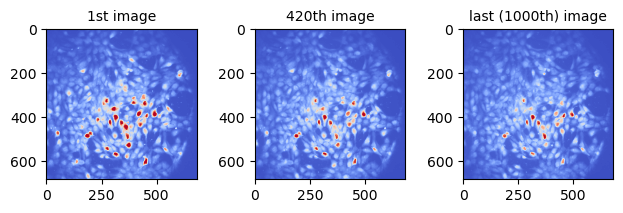

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.tight_layout()
ax1.set_title("1st image", fontsize=10)
ax1.imshow(img[0], cmap="coolwarm") 
ax2.set_title("420th image", fontsize=10)
ax2.imshow(img[419], cmap="coolwarm") 
ax3.set_title("last (1000th) image", fontsize=10)
ax3.imshow(img[999], cmap="coolwarm") 

In [5]:
mean_img = (np.mean(img_array, axis = 0))


Note: it is too computationally expensive to calculate the entire 682 x 682 standard deviation matrix at once (i.e. kernel crashes), so I calculated multiple sub-arrays and concatenated them in std_img for the full matrix

In [7]:
std1 = (np.std(img_array[:, :, : 200], axis = 0))

In [8]:
std2 = (np.std(img_array[:, :, 200 : 400 ], axis = 0))

In [9]:
std3 = (np.std(img_array[:, :, 400 : ], axis = 0))

In [10]:
std_img = np.concatenate((std1, std2, std3), axis=1)

### Measure variance of image

In [11]:
cv_img = std_img / mean_img # coefficient of variation or relative standard deviation
v2_mean_img = (std_img * std_img) / mean_img # variance to mean ratio
recip_img = mean_img / std_img # reciprocal ratio (SNR)
recip_sqimg = (mean_img / std_img) ** 2 # ^^ squared
eff_img = cv_img ** 2 # efficiency

/var/folders/_c/3ryrb96d5p152b08284fyjvm0000gn/T/ipykernel_5554/451648303.py:3: RuntimeWarning: divide by zero encountered in true_divide
  recip_img = mean_img / std_img # reciprocal ratio (SNR)
/var/folders/_c/3ryrb96d5p152b08284fyjvm0000gn/T/ipykernel_5554/451648303.py:4: RuntimeWarning: divide by zero encountered in true_divide
  recip_sqimg = (mean_img / std_img) ** 2 # ^^ squared


Plots

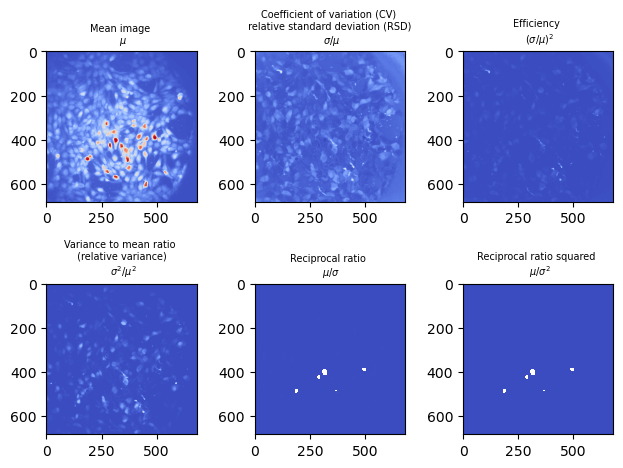

In [13]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3)
fig.tight_layout()

ax1.set_title("Mean image \n $\mu$", fontsize=7)
ax1.imshow(mean_img, cmap='coolwarm')

ax2.set_title("Coefficient of variation (CV) \n relative standard deviation (RSD) \n $\sigma / \mu$", fontsize=7)
ax2.imshow(cv_img, cmap='coolwarm')

ax3.set_title("Efficiency \n $(\sigma / \mu)^2$", fontsize=7)
ax3.imshow(eff_img, cmap='coolwarm')

ax4.set_title("Variance to mean ratio \n (relative variance) \n $\sigma^2 / \mu^2$", fontsize=7)
ax4.imshow(v2_mean_img, cmap='coolwarm')

ax5.set_title("Reciprocal ratio \n $\mu / \sigma$", fontsize=7)
ax5.imshow(recip_img, cmap='coolwarm')

ax6.set_title("Reciprocal ratio squared \n $\mu / \sigma^2$", fontsize=7)
ax6.imshow(recip_sqimg, cmap='coolwarm')

### Identify cell centers

Load from file

In [ ]:
# blobs_dog = '../data/insert_path_here'

Automatic (difference of gaussian)

In [6]:
blobs_dog = blob_dog(mean_img, min_sigma=7, max_sigma=10, threshold=0.005)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

In [7]:
xc = blobs_dog[:, 0]
yc = blobs_dog[:, 1]
num_neurons = blobs_dog.shape[0]

Plots

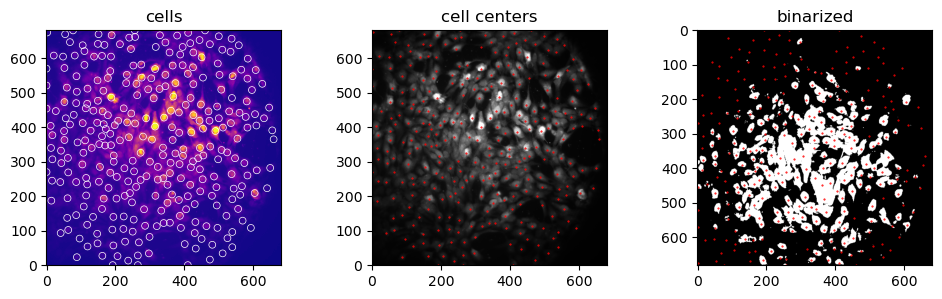

In [129]:


fig2, (ax, ax2, ax3) = plt.subplots(1, 3)
fig2.tight_layout()
fig2.set_figwidth(10)

# ax = plt.gca()
ax.set_title("cells")
ax.imshow(mean_img,origin='lower', cmap="plasma")
for cnt in range (0, len(blobs_dog)):
    c = plt.Circle((blobs_dog[cnt][1], blobs_dog[cnt][0]), blobs_dog[cnt][2], color='white', linewidth=0.5, fill=False)
    ax.add_patch(c)

ax2.imshow(mean_img,origin='lower', cmap="gray")
ax2.xlim=(0, 682)
ax2.ylim=(0, 682)
ax2.set_aspect('equal')
ax2.set_facecolor("black")
ax2.set_title("cell centers")
for i in range(0, len(blobs_dog)):
    ax2.plot(blobs_dog[i][1], blobs_dog[i][0], marker="o", c="red", markersize=0.5)

ax3.set_title("binarized")
ax3.imshow(mean_img > 0.2, cmap="gray")
for i in range(0, len(blobs_dog)):
    ax3.plot(blobs_dog[i][1], blobs_dog[i][0], marker="o", c="red", markersize=0.5)


### Extract fluorescence over time from a circle around selected cell coordinates; define cell-by-cell custon ROIs based on fluo

In [8]:
def extract_roibw(img, xc, yc, enrp):
    """
    PARAMS
    img (x dim, y dim): array for image
    xc, yc (# of cells): x and y coords of cell centers, respectively
    enrp (int): expected neuron radius pix

    RETURNS: 
    roi_bw: (# cells, x dim, y dim): isolate each cell by creating a binarized mask of each roi, i.e. each row = an image w/ just that cell 
    """

    nn = len(xc) 
    x_dim = img.shape[1]
    y_dim = img.shape[2]
    r = np.zeros([nn, x_dim, y_dim]) 

    for i in range(nn):
        temp = np.zeros([x_dim, y_dim])
        for x in range(int(xc[i] - enrp), int(xc[i] + enrp)):
            for y in range(int(yc[i] - enrp), int(yc[i] + enrp)):
                if y < y_dim and y > 0 and x < x_dim and x > 0:
                    if np.sqrt((x - xc[i]) ** 2 + (y - yc[i]) ** 2) <= enrp: # if curr pixel is w/in radius dist from cell center
                        temp[x, y]= 1 # set to light (ie cell)
        r[i, :, :] = temp
                    
    return r

In [9]:
roibw = extract_roibw(img_array, xc, yc, expected_neuron_radius_pix)

In [10]:
def extract_raw_fluo(img, nn, roibw):
    """
    PARAMS
    img (x dim, y dim): np array of image
    nn (int): num neurons
    roibw (x dim, y dim): see above

    RETURNS: 
    raw_fluo (frames, # cells): raw fluorescent intensity over time; row = frame, col = cell
    """
    
    frames = img.shape[0] 

    r = np.zeros([frames, nn]) # each col is a cell's (change in) fluorescence over time

    for i in range(nn):

        # finding valid pixels
        rows, cols = [], [] # row + col indices for pixels w/ cells
        for index, px in np.ndenumerate(roibw[i, :, :]): # enumerate through the image in roibw for specified neuron
            if px == 1: # if cell exists there -> add to lists of saved rows + cols
                rows.append(index[0])
                cols.append(index[1])

        # taking average for each frame + adding to ret
        for fr in range(frames):
            avg_list = [] # fluo at each pixel w/ cell
            for j in range(len(rows)):
                avg_list.append(img[fr, rows[j], cols[j]]) 
            avg_fluo = np.mean(avg_list) # cell's overall fluo in that frame
            r[fr, i] = avg_fluo

    return r

In [11]:
raw_fluo = extract_raw_fluo(img_array, num_neurons, roibw)

### dF/F calculation

In [45]:
# norm_f = raw_fluo / np.max(raw_fluo[:])
# note: norm_f was in the matlab script, but it is almost never necessary here in python b/c the img_array values are 0-1, not 0-255
# thus, norm_f == raw_fluo, b/c norm_f is just dividiing everything by 1 (unless none of the cells are at max brightness (i.e. == 1), which is unlikely)

In [12]:
def slide_win_sub(f, win_size, percent):
    """
    PARAMS
    f: raw fluorescence (frames, cells)
    win_size: baseline window size
    percent: lower % of baseline values to avg

    RETURNS
    dff (frames, cells): relative change in fluorescence in percent
    """

    nn = f.shape[1] # num of ROIS = num of cells
    frames = f.shape[0]
    dff = np.zeros([frames, nn])

    for n in range(0, nn):
        for fr in range(0, frames):
            # boundaries for window
            lw = max(0, fr - win_size)
            rw = min(fr + win_size, frames - 1)
            percent_win = np.floor(percent / 100 * (rw - lw))
            tw = np.sort(f[lw : rw, n]) # sort fluo vals for that cell in the window
            f0 = np.mean(tw[0 : int(percent_win)]) # avg of bottom bottom [percent] percentile of fluo vals in window
            dff[fr, n - 1] = (f[fr, n] - f0) / f0 # normalize fluo: raw fluo wrt the average of the bottom [percent] percentile in the window

    return dff

In [144]:
dff = slide_win_sub(raw_fluo, dff_baseline_size, dff_baseline_percent)

In [145]:
def dff_active(dff):
    """
    PARAMS
    dff (frames, # cells) dff

    RETURNS
    (frames, # cells): any cells w/ < 3 peaks are considered inactive 
    """
    r = dff

    for n in range(0, dff.shape[1]):
        signal, _ = signal.find_peaks(dff[:, n])
        if len(signal) < 3: # if < 3 peaks => replace w NaN
            r[:, n].fill(np.nan)

    return r

In [146]:
dff_active = dff_active(dff)

## Plot dF/F

In [280]:
def plot_matrix_activity(fluo, dff):
    """
    PARAMS
    fluo, dff (frames, # cells): fluo and dff matrices

    PRINTS
    heatmaps of fluo and dff over time
    """
    fig, axs = plt.subplots(3, 1)
    fig.tight_layout()
    fig.set_figwidth(10)
    fig.set_figheight(6)
    sns.heatmap(data=np.transpose(fluo), ax=axs[0], cmap="BuPu").set(title="fluorescence over time")
    sns.heatmap(data=np.transpose(dff), ax=axs[1], cmap="BuPu").set(title="df/f over time")
    sns.scatterplot(data=dff, ax=axs[2], cmap="BuPu").set(title="df/f over time")

### Look for peaks (test)

In [147]:
def look_for_peaks(fluo):
    """
    PARAMS
    dff (frames, cells)

    RETURNS
    list of dicts (len = # of peaks), where each element represents a cell
    keys = frame of peak, values = height of peak
    shows frames where a cell has the most activity, i.e. brightest
    """
    r = []
    for n in range(fluo.shape[1]):
        sig = fluo[:, n]
        locs, _ = signal.find_peaks(sig, prominence = np.std(sig) * 3)
        pks = [sig[locs[i]] for i in range(len(locs))]
        r.append(dict(zip(locs, pks)))
    return r

In [177]:
peaks = look_for_peaks(raw_fluo)
peaks_dff = look_for_peaks(dff)

In [263]:
def plot_trace_activity(n, peaks, peaks_dff):
    """
    PARAMS
    n: neuron #
    peaks, dff_peaks: dict, keys = location of peaks, values = height

    PRINTS
    plots of calcium activity + change in activity over time
    peaks (w/ prominence defined above)
    """

    fig3, (ax1, ax2) = plt.subplots(2, 1)
    fig3.tight_layout()
    fig3.set_figwidth(10)
    fig3.set_figheight(5)

    # calcium activity
    locs = peaks[n].keys()
    pks = peaks[n].values()
    ax1.plot(raw_fluo[:, n], linewidth=0.5)
    ax1.plot(locs, pks, "x")
    ax1.set_title("calcium activity for neuron #" + str(n))
    ax1.set_xlabel("frame #")
    ax1.set_ylabel("brightness (activity)")

    # change in calcium activity
    locs_dff = peaks_dff[n].keys()
    pks_dff = peaks_dff[n].values()
    ax2.plot(dff[:, n], linewidth=0.5)
    ax2.plot(locs_dff, pks_dff, "x")
    ax2.set_title("change in calcium activity for neuron #" + str(n))
    ax2.set_xlabel("frame #")
    ax2.set_ylabel("change in fluorescence (dF/F)")
    ax2.axhline(y = 0, linewidth=0.2, color='g')# plot a random trace



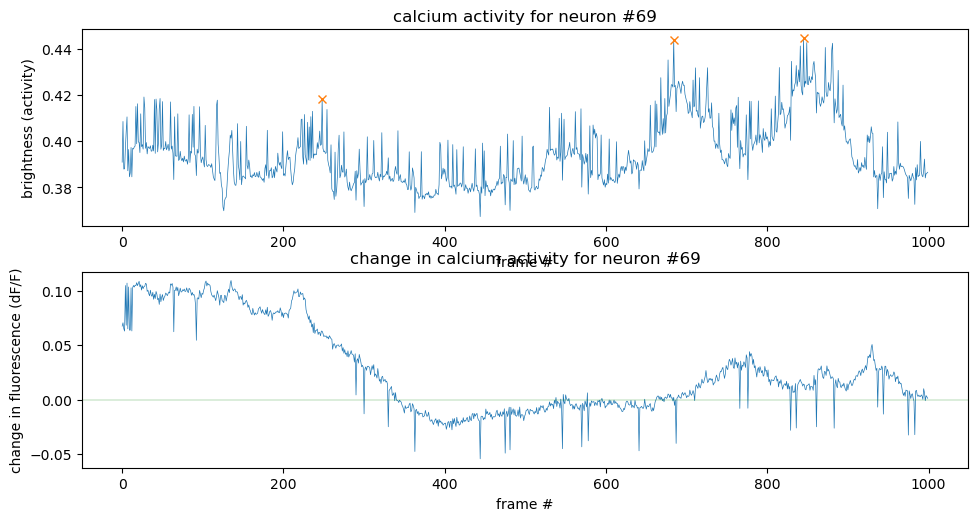

In [265]:
plot_trace_activity(69, peaks, peaks_dff)

### Correlation coefficient (test)

In [200]:
cor_mat = np.corrcoef(np.transpose(dff))

### Cross correlation (test)

In [257]:
# pearson correlation, but w/ time lag
def cross_correlation(dff): 
    """
    PARAMS
    dff (frames, # cells): dff matrix

    RETURNS
    tuple (len = # of neurons): [0] = matrix of cross correlations, [1] = matrix of lags
    """
    c_max = dff.shape[1]
    xcormat, xcorlagmat = np.zeros([c_max, c_max]), np.zeros([c_max, c_max])

    for c1 in range(c_max):
        for c2 in range(c_max):
            sig1, sig2 = dff[:, c1], dff[:, c2]
            corrs = np.correlate(a=sig1, v=sig2)
            corrs = corrs / ((len(sig2) * np.std(sig1) * np.std(sig2))) # Normalization
            lags = signal.correlation_lags(sig1.size, sig2.size)
            
            max_index = 0
            for i in range(len(corrs)):
                if abs(corrs[i]) == max(abs(corrs)):
                    max_index = i
                    break
            
            xcormat[c1, c2] = corrs[max_index]
            xcorlagmat[c1, c2] = lags[max_index] if abs(lags[max_index]) < 750 else 750

    return (xcormat, xcorlagmat)

xcormat = cross_correlation(dff)[0] 
xcorlagmat = cross_correlation(dff)[1]

### Distance matrix

### Plot dF/F and correlation matrix

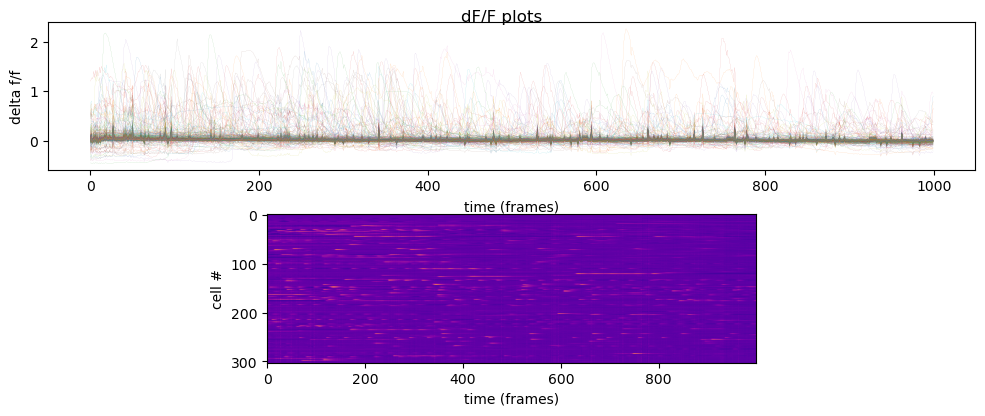

In [286]:
def plot_dff(dff):
    """
    PARAMS
    dff (frames, # cells)

    PRINTS
    scatterplot of df/f values wrt frames
    heatmap of df/f- each cell's change in fluo
    """

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 4))
    fig.tight_layout()
    fig.suptitle("dF/F plots")

    ax1.plot(dff, linewidth="0.05")
    ax1.set_xlabel("time (frames)")
    ax1.set_ylabel("delta f/f")
    
    ax2.imshow(np.transpose(dff), cmap="plasma")
    ax2.set_xlabel("time (frames)")
    ax2.set_ylabel("cell #")

plot_dff(dff)

In [ ]:
def plot_corr(cor_mat, xcormat, xcorlagmat):
    

plot_corr(cor_mat, xcormat, xcorlagmat)

### Get triangles

### Plot distance v correlation scatters

FUNCTION: binned mean

FUNCTION: scatter kernel density estimate

kernel density estimate

desu density scattercloud

### Histogram of correlation coefficient